##Ventilator Pressure Lab 2
Author: Luciana Restrepo Cadavid

CC 1001017585

Maestría en metrología

08/10/2025

##Contextualization

Mechanical ventilation is a critical life-support intervention used to assist patients with respiratory failure. Its effectiveness depends on the accurate control of pressure, flow, and volume parameters. To analyze these relationships, the Ventilator Pressure Prediction dataset from Kaggle was selected.

This dataset simulates respiratory cycles using an open-source ventilator connected to a test lung. It records time-series data of six main signals: time_step, u_in, u_out, pressure, R, and C. Each simulated breath lasts approximately three seconds, and the database contains over 600,000 observations corresponding to multiple breath cycles.

These data allow the modeling and prediction of airway pressure dynamics based on ventilator control inputs and lung characteristics, supporting research on optimizing ventilator settings and enhancing patient safety.

**References:**

[1] Amato, M. B. P., et al. (2015). Driving pressure and survival in the acute respiratory distress syndrome. New England Journal of Medicine, 372(8), 747–755.

[2] Kaggle. Ventilator Pressure Prediction Competition. Retrieved from https://www.kaggle.com/c/ventilator-pressure-prediction

##Library and dataset calling


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


train = pd.read_csv("/content/drive/MyDrive/Datasets lab1/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets lab1/test.csv")
sample = pd.read_csv("/content/drive/MyDrive/Datasets lab1/sample_submission.csv")

In [3]:
# General information
print("Train dataset:")
print(train.head())

print("\nTest dataset:")
print(test.head())

print("\nSample dataset:")
print(sample.head())

print("\nGeneral information about train dataset:")
print(train.info())

print("\nNull values by columns:")
print(train.isnull().sum())

Train dataset:
   id  breath_id   R   C  time_step       u_in  u_out   pressure
0   1          1  20  50   0.000000   0.083334      0   5.837492
1   2          1  20  50   0.033652  18.383041      0   5.907794
2   3          1  20  50   0.067514  22.509278      0   7.876254
3   4          1  20  50   0.101542  22.808822      0  11.742872
4   5          1  20  50   0.135756  25.355850      0  12.234987

Test dataset:
   id  breath_id  R   C  time_step       u_in  u_out
0   1          0  5  20   0.000000   0.000000      0
1   2          0  5  20   0.031904   7.515046      0
2   3          0  5  20   0.063827  14.651675      0
3   4          0  5  20   0.095751  21.230610      0
4   5          0  5  20   0.127644  26.320956      0

Sample dataset:
   id  pressure
0   1         0
1   2         0
2   3         0
3   4         0
4   5         0

General information about train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 colum

In [4]:
# Analyze duplicated data
duplicated = train.duplicated().sum()
print(f"\nDuplicated rows: {duplicated}")



Duplicated rows: 0


In [5]:
# General information
print("Train dataset:")
print(train.shape)

print("Test dataset:")
print(test.shape)

print("Sample dataset:")
print(sample.shape)

Train dataset:
(6036000, 8)
Test dataset:
(4024000, 7)
Sample dataset:
(4024000, 2)


## Dataset description
- Train: This file contains the main data used for analysis and model training. It includes complete information for each simulated breath, such as the control inputs (u_in, u_out), lung parameters (R, C), and the corresponding target variable, which is the **airway pressure**. Each record represents a specific time step within a 3-second simulated breath.

- Test: This file contains similar input variables (u_in, u_out, R, C, and time_step) **but does not include the airway pressure values**, as it is used to evaluate the models predictive performance. It simulates new breathing cycles for which the pressure must be estimated.

- Sample: This file provides the template for submission in the Kaggle competition. It includes two columns: id and pressure. The id corresponds to each observation in the test set, and the pressure column is left empty so that users can fill it with their models predictions.

In [6]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [7]:
sample.head()

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [8]:
# Taking a sample to see how it´s distributed the data
train_sample = train.sample(n=10000, random_state=42)

print(train_sample.shape)

(10000, 8)


## Data visualization

The following graphs illustrate the main characteristics of the database.
In the first graph, the relationship between time_step and pressure (from the selected sample) can be observed, showing an asymmetric distribution pattern.

 The second graph displays the pressure distribution, which is primarily concentrated between approximately 2 and 10 cmH₂O, with a smaller tail extending up to 40 cmH₂O.

The third graph represents the time distribution, corresponding to the timestamp of the measurement within the breath.

 The next two graphs show the distributions of resistance and compliance, respectively. Resistance values can be observed around 5, 10, and 50 cmH₂O/L/s, indicating the change in pressure per change in flow (air volume per time). For compliance, values fluctuate between approximately 10, 20, and 50 mL/cmH₂O, representing the change in volume per change in pressure.

 Finally, the graph of the Distribution of Airway Pressure corresponds to the airway pressure measured in the respiratory circuit, expressed in cmH₂O. A peak can be observed around approximately 7 cmH₂O, with a distribution tail extending up to nearly 40 cmH₂O.


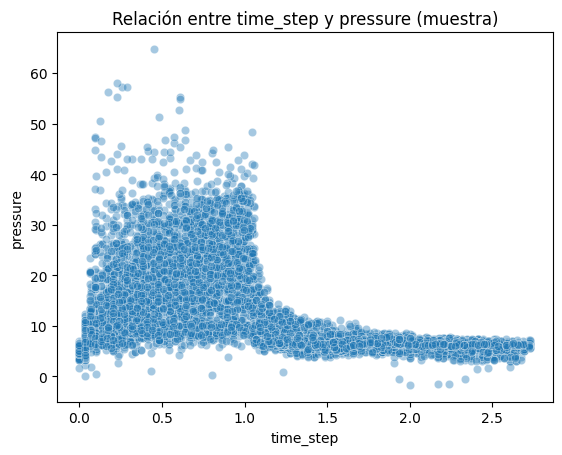

In [9]:
sns.scatterplot(x='time_step', y='pressure', data=train_sample, alpha=0.4)
plt.title('Relación entre time_step y pressure (muestra)')
plt.show()

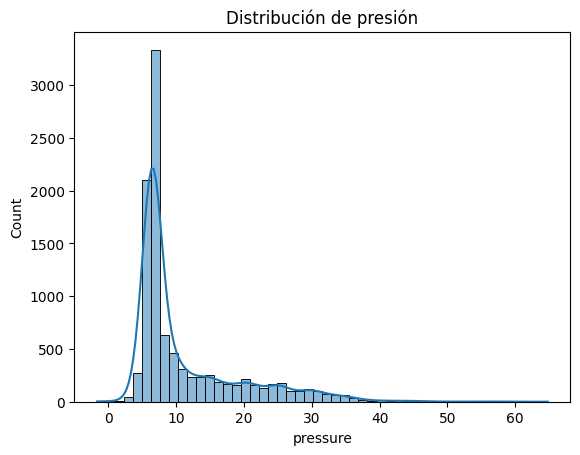

In [10]:
sns.histplot(train_sample['pressure'], bins=50, kde=True)
plt.title('Distribución de presión')
plt.show()

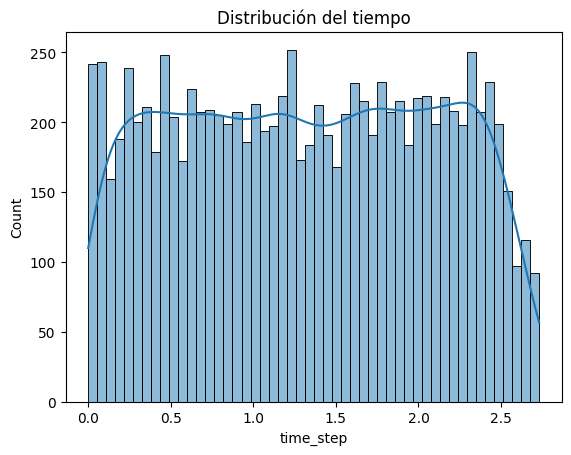

In [11]:
sns.histplot(train_sample['time_step'], bins=50, kde=True)
plt.title('Distribución del tiempo')
plt.show()

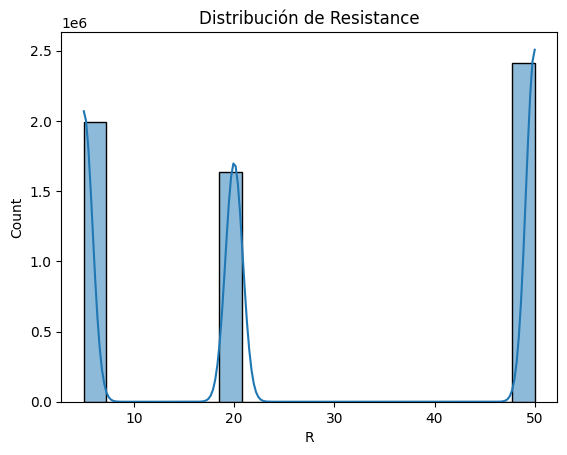

In [12]:
sns.histplot(train['R'], bins=20, kde=True)
plt.title('Distribución de Resistance')
plt.show()

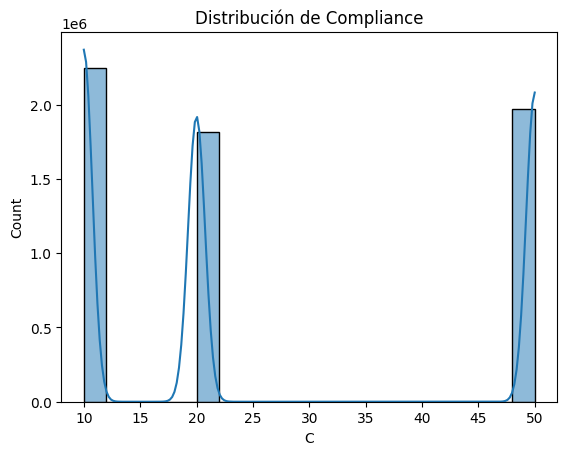

In [13]:
sns.histplot(train['C'], bins=20, kde=True)
plt.title('Distribución de Compliance')
plt.show()

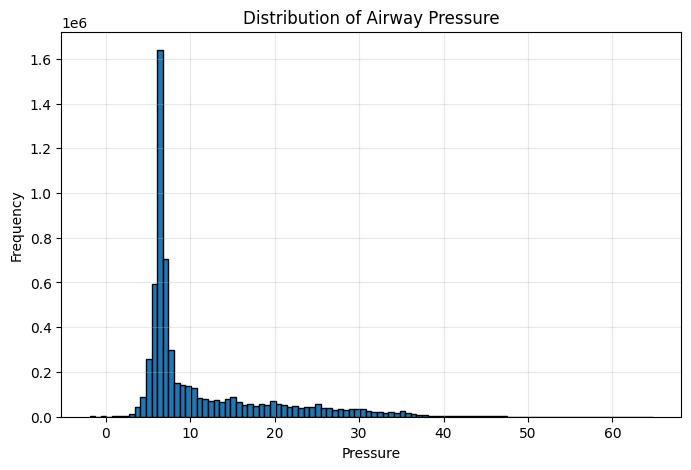

In [14]:
plt.figure(figsize=(8,5))
plt.hist(train["pressure"], bins=100, edgecolor='black')
plt.title("Distribution of Airway Pressure")
plt.xlabel("Pressure")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Advanced Data Handling with Pandas


In [15]:
# Check missing values
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0]
missing_train


,0


In [16]:
# Example handling missing values
# Numeric columns: fill with median
#numeric_cols = train.select_dtypes(include=np.number).columns
#train[numeric_cols] = train[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Categorical columns: fill with mode
#categorical_cols = train.select_dtypes(exclude=np.number).columns
#train[categorical_cols] = train[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Recheck
#train.isnull().sum().sum()


## Handling Missing Data

To ensure dataset integrity, we treat missing data as follows:
- **Numeric features**: replaced with the median to reduce the impact of outliers.
- **Categorical features**: replaced with the mode, which preserves the most frequent category.


In this case, the dataset its already clean and complete, so only the example is left in terms of visualization.

In [17]:
# Detect outliers using IQR (Interquartile Range)
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

# Define filter condition
condition = ~((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).any(axis=1)
train_clean = train[condition]

print("Original shape:", train.shape)
print("After removing outliers:", train_clean.shape)


Original shape: (6036000, 8)
After removing outliers: (4831453, 8)


To ensure data reliability, it is analyzed potential outliers in the variable pressure using the Interquartile Range (IQR) method. This approach identifies values that fall far outside the central distribution of the data.

##Outlier analysis
Outlier Detection and Removal

Outliers can bias statistical results and reduce model accuracy.  
We use the **Interquartile Range (IQR)** method to identify and remove records that fall outside the normal range of values (1.5×IQR).  

This ensures a more representative and stable dataset for analysis.

In [18]:
# Create a copy of the dataset
train_clean = train_clean.copy()

# Create a new derived variable: relationship between pressure and u_in
train_clean["pressure_ratio"] = train_clean["pressure"] / (train_clean["u_in"] + 1)

# Create a derived variable: difference between consecutive pressure values within the same breath_id
train_clean["delta_pressure"] = train_clean.groupby("breath_id")["pressure"].diff().fillna(0)

# Create a categorical variable: classify the resistance values (R) into descriptive levels
train_clean["R_category"] = train_clean["R"].map({5: "Low", 20: "Medium", 50: "High"})

# Display the first few rows of the modified dataset
train_clean.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,pressure_ratio,delta_pressure,R_category
0,1,1,20,50,0.000000,0.083334,0,5.837492,5.388451,0.000000,Medium
30,31,1,20,50,1.021298,0.000000,1,19.546410,19.546410,13.708918,Medium
31,32,1,20,50,1.055426,0.000000,1,17.015533,17.015533,-2.530877,Medium
32,33,1,20,50,1.089404,0.000000,1,9.563505,9.563505,-7.452027,Medium
33,34,1,20,50,1.123387,0.000000,1,7.876254,7.876254,-1.687251,Medium


###  Data Restructuring and Transformation

In this section, it´s perform data restructuring and feature transformation to enhance interpretability and analytical value.  
The dataset represents ventilator pressure measurements, so creating derived variables allows to understand way better the mechanical and physiological behavior of the system.

**Transformations applied:**

- **Pressure Ratio as (`pressure_ratio`)**:  
  Created by dividing the airway pressure (`pressure`) by the input flow (`u_in + 1`).  
  This derived variable highlights the relationship between pressure and airflow, which can reflect the resistance or compliance of the ventilatory system.

- **Pressure Variation as (`delta_pressure`)**:  
  Computed as the difference between consecutive pressure measurements within each breath (`breath_id`).  
  This feature captures the dynamic behavior of pressure changes over time, providing insight into the system's response during inspiration and expiration cycles.

- **Resistance Category (`R_category`)**:  
  The numeric resistance values (`R`) are transformed into categorical labels:  
  - `5 → Low`

  - `20 → Medium`

  - `50 → High`  
  This enhances interpretability, allowing the analysis of pressure and flow under different resistance conditions.

In [19]:
# Select only numeric columns for variance analysis
numeric_cols = train_clean.select_dtypes(include=['float64', 'int64'])

# Compute the variance of each numeric feature
variances = numeric_cols.var().sort_values(ascending=False)

# Identify the top 5 features with the highest variance
top_features = variances.head(5).index

# Filter the dataset to keep only these top features
filtered_data = numeric_cols[top_features]

# Display the first few rows of the filtered dataset
filtered_data.head()


,id,breath_id,R,C,pressure_ratio
0,1,1,20,50,5.388451
30,31,1,20,50,19.546410
31,32,1,20,50,17.015533
32,33,1,20,50,9.563505
33,34,1,20,50,7.876254


## Selection of High-Variance Features

This step it´s focused on identifying the most variable numerical features in the dataset.
High variance indicates that a feature changes significantly across observations.

The procedure was as follows:

1. **Numeric Column Selection:**  
   Only numerical variables (`float64` and `int64` types) were selected from the dataset to ensure that the variance computation is clean.

2. **Variance Calculation:**  
   The variance of each numerical column was calculated using the `var()` function.
   This metric quantifies how much each feature fluctuates around its mean value.

3. **Top 5 Features Extraction:**  
   The features were sorted in descending order according to their variance,
   and the five with the highest values were selected for visualization.

4. **Dataset Filtering:**  
   A new DataFrame (`filtered_data`) was created containing only these top five features,
   allowing focused analysis on the most variable parameters.

This approach helps to highlight the key variables that may have a stronger impact on the system behavior or model performance.


In [20]:
# Base class for feature extraction
class FeatureExtractor:
    def __init__(self, data, signal_col, group_col):

        self.data = data
        self.signal_col = signal_col
        self.group_col = group_col

    def extract(self):

        raise NotImplementedError("Subclasses must implement this method.")


# Subclass for time-domain features
class SimpleTimeFeatures(FeatureExtractor):
    def extract(self):
        """
        Extract simple time-domain statistical features for each breath.
        """
        grouped = self.data.groupby(self.group_col)[self.signal_col]
        features = grouped.agg([
            'mean',     # Average pressure
            'std',      # Pressure variability
            'max',      # Peak pressure
            'min'       # Minimum pressure
        ])
        # Calculate RMS (Root Mean Square) manually
        features['rms'] = grouped.apply(lambda x: np.sqrt(np.mean(x**2)))
        return features.reset_index()


# Apply the class
simple_features = SimpleTimeFeatures(train_clean, signal_col='pressure', group_col='breath_id')
feature_results = simple_features.extract()

feature_results.head()


,breath_id,mean,std,max,min,rms
0,1,7.590910,2.296951,19.546410,5.837492,7.924295
1,2,9.395150,4.458303,18.562180,4.993866,10.386712
2,3,10.803278,7.071372,24.537862,5.064168,12.881048
3,4,8.929634,4.927983,23.764539,5.767190,10.179649
4,5,7.193910,2.969225,19.405806,4.853262,7.771471


## Feature Extraction Using OOP
  
A base class called `FeatureExtractor` was created, and a subclass `SimpleTimeFeatures` was defined to compute statistical features in the **time domain**.

For each breath (`breath_id`), we calculated:
- **Mean:** Represents the average pressure value.
- **Standard deviation:** Describes how much the pressure fluctuates.
- **Maximum and minimum:** Indicate the range of pressure values.
- **RMS (Root Mean Square):** Reflects the overall signal energy.

These features are relevant because they help to describe the behavior of the pressure signal over time, which is key for analyzing the ventilator’s performance and detecting anomalies in the pressure profiles.

In [21]:
# Copy dataset to avoid warnings
data_stats = train_clean.copy()

# Select numerical features for statistical analysis
numeric_features = ["pressure", "u_in", "u_out", "pressure_ratio", "delta_pressure"]


# Calculate mean, median, std, variance, etc.
descriptive_stats = data_stats[numeric_features].describe().T
descriptive_stats["variance"] = data_stats[numeric_features].var()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max,variance
pressure,4831453.0,8.295480,4.089400,-1.895744,6.189002,6.681117,8.368369,24.537862,16.723196
u_in,4831453.0,3.166100,2.594419,0.000000,0.000000,3.786994,4.907455,11.869205,6.731012
u_out,4831453.0,0.759621,0.427314,0.000000,1.000000,1.000000,1.000000,1.000000,0.182597
pressure_ratio,4831453.0,3.712281,4.126677,-1.825442,1.120961,1.660308,5.837492,24.537862,17.029465
delta_pressure,4831453.0,-0.046084,1.514213,-18.770673,-0.281209,0.000000,0.281209,22.988802,2.292843


## Statistical analysis

It´s computed key descriptive statistics such as mean, median, standard deviation, and variance for the main numeric variables in the dataset.
These measures summarize the central tendency and variability of the signals, which helps identify how the data behaves under different respiratory conditions.

### **Interpretation of Descriptive Statistics**

The descriptive statistics provide an overview of the key numerical features in the dataset.

- Pressure: The mean pressure is around 8.29 cmH₂O with a standard deviation of 4.09, indicating moderate variability. The minimum and maximum values range from -1.89 to 24.54, suggesting that some negative or near-zero pressures occur, possibly during the release phase of ventilation.

- u_in:The mean value of 3.17 and a relatively high variance (6.73) show that the input flow varies significantly across breaths, which is expected due to different respiratory cycles and resistance levels.

- u_out: This variable has a low variance (0.18) and discrete behavior, as it mainly alternates between 0 and 1, representing whether the valve is open or closed.

- pressure_ratio: With a variance of 17.03, this derived variable (pressure divided by u_in) shows high dispersion, meaning that the relationship between these two parameters fluctuates strongly depending on the breathing phase and mechanical resistance.

- delta_pressure: The near-zero mean and moderate standard deviation (1.51) indicate that, on average, the pressure differences between consecutive time steps are small, but there are occasional large jumps, as seen from the min and max values, which could correspond to fast pressure changes during inhalation or exhalation transitions.

Overall, these metrics highlight that pressure and u_in are the most variable features, and therefore the most informative for analyzing the system’s dynamics and distinguishing between resistance categories.

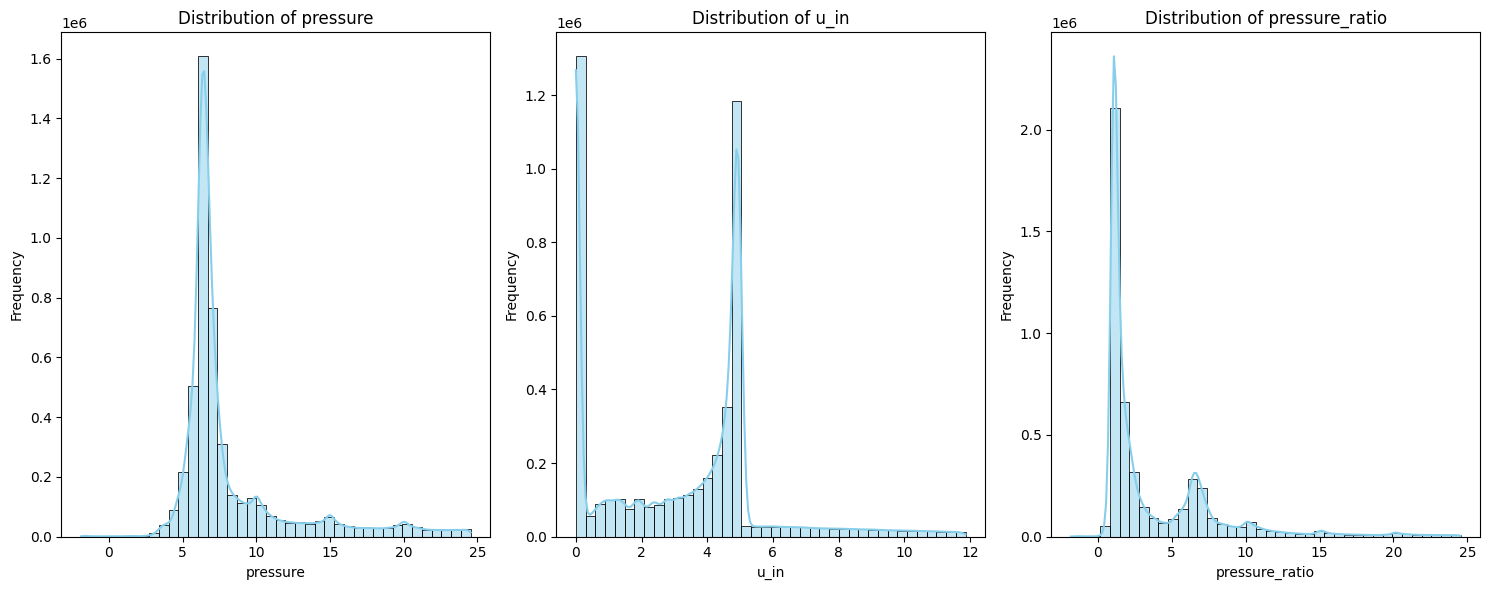

In [24]:
#  Visualizing feature distributions
plt.figure(figsize=(15,6))

for i, feature in enumerate(["pressure", "u_in", "pressure_ratio"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(train_clean[feature],kde=True, bins=40, color="skyblue")
    plt.title(f"Distribution of {feature}", fontsize=12)
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## Visual Distribution Analysis

The histograms above display the frequency distribution of the main numerical variables: pressure, u_in, and pressure_ratio.

- Pressure: shows a pronounced peak around 5–7 cmH₂O, followed by a long right tail. This indicates that most measurements correspond to moderate pressure values, while higher pressures occur less frequently, that´s the typical behavior in ventilator signals where inspiration peaks briefly.

- u_in: presents a bimodal-like distribution, with a strong accumulation of values near 0 and another around 4–5 L/min, representing alternating phases between minimal air input when exhalation happens and active air delivery durin the inhalation.

- pressure_ratio: also shows a right-skewed pattern, with most values concentrated near 0–5, followed by smaller secondary peaks. This suggests variable efficiency in how input flow translates into pressure under different breathing cycles.

Overall, the distributions confirm that the dataset is not normally distributed, which aligns with the expected physiological variability in mechanical ventilation.
This variability reflects the dynamic changes in airway resistance and lung compliance during the breathing process.

# Class separability

## Hypotesis Test (Kolmogorov–Smirnov)


The Kolmogorov–Smirnov test was chosen to evaluate the normality of the data, as the sample size exceeds the recommended limit for the Shapiro–Wilk test, making the former more suitable for large datasets.

In [27]:
from scipy.stats import kstest, zscore


#  Variable categórica y variable numérica a evaluar
group_col = 'R_category'
feature = 'pressure'   # Cambia aquí la variable que quieras probar

print(f"\n Kolmogorov–Smirnov Test for feature: {feature}\n")

# Iterar sobre los grupos
results = []
for g in data_stats[group_col].unique():
    group_data = data_stats[data_stats[group_col] == g][feature].dropna()

    # Normalizar antes de comparar con una normal estándar
    group_data_norm = zscore(group_data)

    # Aplicar prueba KS contra la distribución normal teórica
    stat, p_value = kstest(group_data_norm, 'norm')

    # Interpretación
    normal = "Sí (p > 0.05)" if p_value > 0.05 else "No (p ≤ 0.05)"

    print(f"{g}: Statistic = {stat:.5f}, p-value = {p_value:.5f}")
    print(f"  La distribución de '{feature}' en el grupo '{g}' es normal: {normal}\n")

    results.append({
        'Grupo': g,
        'Estadístico KS': stat,
        'p-value': p_value,
        'Normalidad': normal
    })


 Kolmogorov–Smirnov Test for feature: pressure

Medium: Statistic = 0.27100, p-value = 0.00000
  La distribución de 'pressure' en el grupo 'Medium' es normal: No (p ≤ 0.05)

High: Statistic = 0.29728, p-value = 0.00000
  La distribución de 'pressure' en el grupo 'High' es normal: No (p ≤ 0.05)

Low: Statistic = 0.25374, p-value = 0.00000
  La distribución de 'pressure' en el grupo 'Low' es normal: No (p ≤ 0.05)



The **Kolmogorov–Smirnov (KS)** test was conducted to determine whether the **pressure** data within the *Low*, *Medium*, and *High* groups follow a normal distribution.

#### Hypothesis
- **Null hypothesis (H₀):** The data are normally distributed.  
- **Alternative hypothesis (H₁):** The data are not normally distributed.

#### Decision Criteria
According to the test, the decision rule is established as follows:
- If **p > 0.05**, there is insufficient evidence to reject the null hypothesis, and the data can be considered normally distributed.  
- If **p ≤ 0.05**, the null hypothesis is rejected, indicating that the data do not follow a normal distribution.

#### Results

| Group  | KS Statistic | p-value | Normality |
|:-------:|:-------------:|:--------:|:-----------:|
| Medium | 0.27100 | 0.00000 | No (p ≤ 0.05) |
| High   | 0.29728 | 0.00000 | No (p ≤ 0.05) |
| Low    | 0.25374 | 0.00000 | No (p ≤ 0.05) |

#### Interpretation
The obtained p-values for all groups were below the significance level of 0.05. Consequently, the null hypothesis of normality is rejected in every case.  
This implies that the variable `pressure` does not follow a normal distribution within the analyzed groups (*Low*, *Medium*, and *High*).  

From a statistical standpoint, these findings suggest that subsequent analyses should consider **non-parametric methods** or apply **data transformations** if normality is required for further procedures.

# Non-Parametric Statistical Test Selection: Kruskal–Wallis Test

Since the results of the Kolmogorov–Smirnov test indicated that the `pressure` data do not follow a normal distribution (p ≤ 0.05 in all groups), the use of **parametric tests** such as the one-way ANOVA is not appropriate.  
Therefore, a **non-parametric alternative** must be employed.

According to the criteria established in standard statistical methodology, when comparing **three or more independent groups** with **non-normally distributed data**, the appropriate test is the **Kruskal–Wallis test**.

#### Characteristics of the Kruskal–Wallis Test
- **Type of data:** Continuous or ordinal, non-normally distributed.  
- **Number of groups:** Three or more.  
- **Sample relationship:** Independent samples.  
- **Purpose:** To determine whether there are statistically significant differences in the median values among the groups.

#### Hypothesis
- **Null hypothesis (H₀):** The distributions of all groups are equal.  
- **Alternative hypothesis (H₁):** At least one group differs significantly from the others.

#### Interpretation
If the **p-value ≤ 0.05**, the null hypothesis is rejected, indicating that **at least one group’s distribution is significantly different** from the others.  
If the **p-value > 0.05**, there is no statistical evidence of differences among the groups.


The Kruskal–Wallis test is a robust non-parametric method that does not rely on the assumption of normality and is suitable for assessing group differences in the `pressure` variable across the *Low*, *Medium*, and *High* categories.


In [30]:
from scipy.stats import kruskal

low_group = train_clean[train_clean['R_category'] == 'Low']['pressure']
medium_group = train_clean[train_clean['R_category'] == 'Medium']['pressure']
high_group = train_clean[train_clean['R_category'] == 'High']['pressure']

#  Kruskal–Wallis test
stat, p_value = kruskal(low_group, medium_group, high_group)

print("Kruskal–Wallis Test Results")
print(f"Statistic = {stat:.5f}, p-value = {p_value:.5f}")

# Interpretation
if p_value > 0.05:
    print("There is no statistically significant difference among the groups (p > 0.05).")
else:
    print("At least one group differs significantly from the others (p ≤ 0.05).")

Kruskal–Wallis Test Results
Statistic = 72685.65256, p-value = 0.00000
At least one group differs significantly from the others (p ≤ 0.05).


## Results and Interpretation of the Kruskal–Wallis Test

The test was applied to the `pressure` variable across the three independent groups (*Low*, *Medium*, and *High*) to determine whether their distributions differ significantly.

#### Obtained Results
- **Test statistic (H):** 72685.65  
- **p-value:** 0.00000

#### Interpretation
Given that the **p-value ≤ 0.05**, the null hypothesis of equality among group distributions is rejected.  
This indicates that there are **statistically significant differences** in the distribution of `pressure` among at least one of the groups analyzed.

In other words, the median `pressure` values are not equal across all groups. However, the Kruskal–Wallis test does not specify **which** groups differ from each other; it only detects that at least one difference exists.



## Fisher´s Ratio Test

Fisher’s ratio provides a numerical measure of separability.
A higher ratio means that the variable better distinguishes between categories.
This helps identify which features are most relevant for classification or model training.

In [26]:
def fisher_discriminant_analysis(data, group_col, exclude_cols=None):


    if exclude_cols is None:
        exclude_cols = []

    feature_cols = data.select_dtypes(include=[np.number]).columns.drop(exclude_cols, errors='ignore')
    if group_col in feature_cols:
        feature_cols = feature_cols.drop(group_col)


    feature_means_by_class = data.groupby(group_col)[feature_cols].mean()

    print('Mean of feature j in class i:\n')
    print(feature_means_by_class)


    overall_mean = data[feature_cols].mean()

    print('\nOverall mean of feature j:\n')
    print(overall_mean)

    # Within-Class Scatter
    n_features = len(feature_cols)
    within_class_scatter = np.zeros((n_features, n_features))

    for label in data[group_col].unique():
        class_data = data[data[group_col] == label][feature_cols]
        class_mean = feature_means_by_class.loc[label]
        within_class_scatter += np.dot((class_data - class_mean).T, (class_data - class_mean))

    # Between-Class Scatter
    between_class_scatter = np.zeros((n_features, n_features))
    for label, class_mean in feature_means_by_class.iterrows():
        n = len(data[data[group_col] == label])
        mean_diff = (class_mean - overall_mean).values.reshape(-1, 1)
        between_class_scatter += n * np.dot(mean_diff, mean_diff.T)

    # FDR
    fisher_discriminant_ratio = np.diag(
        np.dot(np.linalg.pinv(within_class_scatter), between_class_scatter)
    )


    print('\nFDR:\n')
    for i, feature in enumerate(feature_cols):
        print(f'{feature}: {fisher_discriminant_ratio[i]:.6f}')


    return pd.Series(fisher_discriminant_ratio, index=feature_cols, name="FDR")



fisher_results = fisher_discriminant_analysis(
    data=data_stats,
    group_col="R_category",
    exclude_cols=["ID"]
)

Mean of feature j in class i:

                      id     breath_id     R          C  time_step      u_in  \
R_category                                                                     
High        3.022719e+06  62937.516014  50.0  23.615327   1.425590  3.112881   
Low         3.014617e+06  62767.961885   5.0  25.935461   1.572001  3.175497   
Medium      3.022240e+06  62926.765322  20.0  28.624931   1.546515  3.239271   

               u_out  pressure  pressure_ratio  delta_pressure  
R_category                                                      
High        0.710433  8.587510        3.576628       -0.022853  
Low         0.803681  8.137245        3.947259       -0.075398  
Medium      0.785530  8.019763        3.649912       -0.048291  

Overall mean of feature j:

id                3.020052e+06
breath_id         6.288151e+04
R                 2.792139e+01
C                 2.567401e+01
time_step         1.503622e+00
u_in              3.166100e+00
u_out             7.596206e-

#### Fisher’s Ratio Analysis

The Fisher Discriminant Ratio (FDR) was applied to evaluate the discriminative power of each variable with respect to the resistance categories (R_category: Low, Medium, and High). This metric quantifies the ability of a feature to differentiate between predefined groups, where higher FDR values indicate stronger discrimination.

According to the results, the variables pressure (0.0147), C (compliance) (0.0128), and pressure_ratio (0.0125) presented the highest FDR values, suggesting that these parameters are the most relevant in distinguishing among resistance levels. These features show consistent variations across the three categories, implying a strong relationship with the mechanical behavior associated with each resistance condition.

On the other hand, variables such as time_step, u_in, and u_out exhibited relatively low FDR values, indicating a limited ability to separate the groups. Meanwhile, R, id, and breath_id showed negligible or non-significant discriminative power, as expected, since they correspond to identifiers or directly define the category itself.

Overall, the FDR analysis reveals that pressure, compliance, and pressure_ratio are the most discriminant features, and therefore, they should be prioritized in subsequent modeling or dimensionality reduction processes related to the classification of resistance categories.

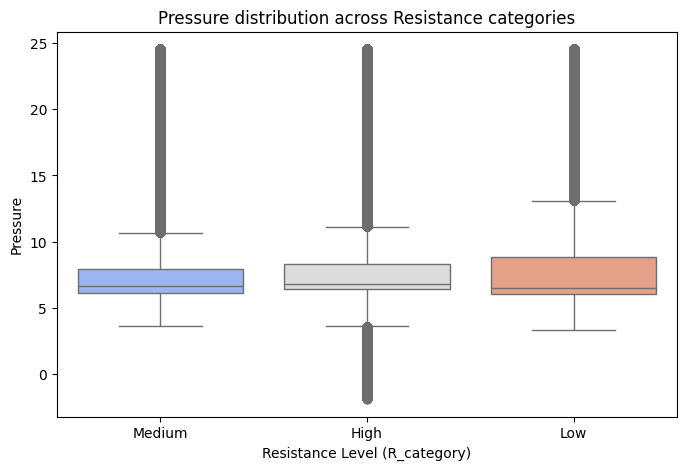

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(x="R_category", y="pressure", data=data_stats, hue="R_category", palette="coolwarm", legend=False)
plt.title("Pressure distribution across Resistance categories")
plt.xlabel("Resistance Level (R_category)")
plt.ylabel("Pressure")
plt.show()


## Data separability

#### Data Separability and Performance Metrics

To assess the separability and predictive consistency within the dataset, a simple linear regression model was trained to estimate pressure based on the variable u_in.
This model represents a basic physical relationship where higher airflow generally leads to an increase in pressure within the ventilatory circuit.

The following performance metrics were computed:

- Root Mean Square Error (RMSE): Indicates the average deviation between measured and predicted pressure values.

- Pearson Correlation Coefficient (r): Quantifies the linear relationship between predicted and actual pressure.

- R² (Coefficient of Determination): Measures the proportion of variance in pressure explained by the predictor variable.

A low RMSE and high r/R² values (close to 1) suggest that the dataset exhibits strong internal consistency, meaning that u_in is a good predictor of pressure.

Conversely, higher RMSE or lower correlation values would indicate a weaker or more complex nonlinear relationship, implying that additional variables (e.g., resistance R or compliance C) might be required to fully describe the system.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Split dataset into train and test sets
X = train_clean[['u_in']]
y = train_clean['pressure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r, _ = pearsonr(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(rmse)
print(r)
print(r2)

4.05970469836188
0.11411570677454122
0.01302167729578807


## Performance Evaluation and Interpretation

The linear regression model between pressure and u_in yielded the following performance metrics:

- RMSE = 4.06

- Pearson correlation (r) = 0.114

- R² = 0.013

These results indicate a weak linear relationship between airflow (u_in) and pressure.

The low correlation and low R² suggest that the relationship is not purely linear and may depend on additional variables such as resistance (R), compliance (C), or valve behavior (u_out).

In summary, the model shows limited predictive power, which highlights the complexity of the ventilatory system and suggests that nonlinear or multivariate models would be more suitable to capture the true dynamics of the pressure–flow interaction.